# Prototyping the GNN Neural Causal Model

The primary objective of this notebook is to develop the core GNN_NCM class. We will take direct inspiration from CXGNN by Berham and then implement our own version using PyTorch Geometric

In [139]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pathlib import Path

# PyTorch Geometric imports
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### Building the GNN Neural Causal Model (GNN_NCM)

Here, we define our core model class. We will include detailed comments explaining how each part corresponds to the concepts in the reference code and the broader SCM framework. The gap between SCMs and GNNs lies mainly in:

1- Directionality: Causality is directed (A -> B is not the same as B -> A), but standard layers like GCNConv are inherently undirected (or symmetric).

2- Modularity vs. Parameter Sharing: An SCM has a unique causal mechanism (f_ij) for each parent-child relationship, while a GNN shares its message-passing weights (ψ) across all edges for scalability.


Therefore to improve causal fidelity we need to do build a GNN layer that is both directional and supports per-edge causal mechanisms, directly addressing the trade-off between common GNNs and SCMs. 

We start by implementing a simple directional message-passing layer


In [140]:
class DirectedGNNLayer(MessagePassing):
    """
    A minimal directed message passing layer where information flows from
    source nodes (parents) to target nodes (children).
    
    It uses a shared MLP for the message function (ψ) and another for the update function (φ).
    """
    def __init__(self, in_dim, hidden_dim, out_dim):
        # flow='source_to_target' is the key argument that enforces directionality.

        super().__init__(aggr='add', flow='source_to_target')

        # ψ (psi): The message function. 
        # It computes a message based on the parent's features.
        self.msg_mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
        
        # φ (phi): The update function. 
        # It updates a node's representation by combining its original features (x_i) with the aggregated messages from all its parents.
        self.update_mlp = nn.Sequential(
            nn.Linear(in_dim + out_dim, hidden_dim), # Takes concatenated [child, aggregated_messages]
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def message(self, x_j, x_i):
        """
        Defines the message from a source node j (parent) to a target node i (child).
        x_j is the parent's feature tensor, x_i is the child's.
        """
        return self.msg_mlp(x_j)

    def forward(self, x, edge_index):
        """ The main propagation method. """
        # special to MessagePassing, self.propagate will call message() for each edge and aggregate() for each node.
        aggregated_messages = self.propagate(edge_index, x=x)
        
        # Combine the node's original state with the messages from its parents.
        updated_embedding = self.update_mlp(torch.cat([x, aggregated_messages], dim=-1))
        return updated_embedding

SCM's structural equations `x_i := f(pa(x_i), U_i)` can have a unique function `f` for each distinct causal relationship. A standard GNN uses one `msg_mlp` for all edges.

We will create a GNN layer that can operate in two modes:
1.  **`'shared'`**: Behaves like a normal GNN (efficient but less causally faithful).
2.  **`'per_edge'`**: Instantiates a unique MLP for every single edge in the graph, (less scalable and requires more training data but causally faithful to SCMs and NCMs).

In [141]:
class EdgeWiseGNNLayer(MessagePassing):
    """
    A GNN layer that resolves the SCM modularity vs. GNN parameter sharing trade-off.
    
    In 'per_edge' mode, it instantiates a unique MLP for each edge, allowing it
    to learn distinct causal mechanisms for each parent-child relationship.
    """
    def __init__(self, in_dim, hidden_dim, out_dim, num_edges, mode='per_edge'):
        super().__init__(aggr='add', flow='source_to_target')
        
        self.mode = mode
        self.num_edges = num_edges
        self.out_dim = out_dim

        if self.mode == 'per_edge':
            # Create a list of MLPs, one for each edge. This is our f_ij.
            # nn.ModuleList is crucial for PyTorch to recognize these as submodules.
            self.edge_mlps = nn.ModuleList([
                nn.Sequential(nn.Linear(in_dim, hidden_dim),nn.ReLU(),nn.Linear(hidden_dim, out_dim)) for i in range(num_edges)
            ])
        elif self.mode == 'shared': 
            # In shared mode, we only have one MLP for all edges.
            self.edge_mlps = nn.Sequential(nn.Linear(in_dim, hidden_dim),nn.ReLU(),nn.Linear(hidden_dim, out_dim))
        else:
            raise ValueError("Mode must be 'shared' or 'per_edge'")
        
        
        # The update function φ remains shared across all nodes.
        self.update_mlp = nn.Sequential(
            nn.Linear(in_dim + out_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, original_edge_ids=None):
        """
        Executes one full message-passing step.

        Args:
            x (Tensor): The input node features.
            edge_index (Tensor): The connectivity for this pass.
            original_edge_ids (Tensor, optional): The original IDs of the edges in edge_index.
                                                   If None, assumes a full graph pass.
        """
        # If the original edge IDs aren't provided, we are doing a standard observational pass.
        if original_edge_ids is None:
            original_edge_ids = torch.arange(self.num_edges, device=x.device)
        
        # The propagate method will call message() and aggregate(), and its output
        # is the aggregated messages for each node.
        aggr_out = self.propagate(edge_index, x=x, original_edge_ids=original_edge_ids)
        
        # The update() method is then called to combine the aggregated messages with
        # the original node features to produce the final node embeddings.
        return self.update(aggr_out, x)


    def message(self, x_j, original_edge_ids):
        """
        Computes the message from parent (x_j) to child.
        
        Args:
            x_j (Tensor): The feature tensor of the source nodes (parents) for each edge.
            edge_ids (Tensor): A tensor containing the index of each edge, which we use
                               to select the appropriate MLP.
        """
        # This is a bit complex, but powerful. We can't apply all MLPs at once.
        # We create a placeholder for the output messages.

        output_messages = torch.zeros(x_j.size(0), self.out_dim, device=x_j.device)
        if self.mode == 'per_edge':
            for i in range(self.num_edges):
                mask = (original_edge_ids == i)
                if mask.any(): output_messages[mask] = self.edge_mlps[i](x_j[mask])
            return output_messages
        else: 
            return self.edge_mlps(x_j)

    def update(self, aggr_out, x):
        return self.update_mlp(torch.cat([x, aggr_out], dim=-1))


## The GNN-NCM Architecture: A Principled SCM Analogue

First, we define our core model architecture. This consists of two main components:

- EdgeWiseGNNLayer: This is our novel GNN layer that resolves the critical trade-off between SCM modularity and GNN parameter sharing. In 'per_edge' mode, it instantiates a unique MLP for each causal link in the graph, directly modeling the SCM principle that each parent -> child relationship has its own distinct mechanism f_ij.
- GNN_NCM: This is the main model class. It orchestrates the EdgeWiseGNNLayers and explicitly implements other SCM principles, namely the inclusion of exogenous noise U and the do_intervention method for simulating interventions.

In [142]:
class GNN_NCM(nn.Module):
    """
    A Graph Neural Network - Neural Causal Model (GNN-NCM).
    
    This model is designed to mimic a Structural Causal Model (SCM). It learns
    from observational data and can then predict outcomes under interventions
    (do-operations) by performing "graph surgery".
    
    This version uses a causally-faithful `EdgeWiseGNNLayer`.
    """
    def __init__(self, num_features, hidden_dim, out_dim, num_edges, noise_dim=4, gnn_mode="per_edge"):
        
        """
        Initializes the GNN-NCM.

        Args:
            num_features (int): The number of input features for each node.
            hidden_dim (int): The dimensionality of the hidden MLPs inside the GNN layers.
            out_dim (int): The output dimensionality of the GNN layers.
            num_edges (int): ### ANNOTATION ### The total number of edges in the full graph.
                               This is a NEW and ESSENTIAL argument for EdgeWiseGNNLayer
                               to know how many unique MLPs to create.
            noise_dim (int): The dimensionality of the exogenous noise vector 'U'.
            gnn_mode (str): Either 'per_edge' for max causal fidelity or 'shared' for efficiency.
        """


        super().__init__()
        self.noise_dim = noise_dim
        self.num_edges = num_edges
        
        # In an SCM, x_i := f(pa(x_i), U_i). We model this by adding noise to the input.

        input_dim = num_features + noise_dim
        
        # Instead of standard GCNConv we use our layer
        self.conv1 = EdgeWiseGNNLayer(
            in_dim=input_dim, 
            out_dim=hidden_dim, 
            hidden_dim=hidden_dim, # Internal MLP size
            num_edges=num_edges, 
            mode=gnn_mode
        )

        self.conv2 = EdgeWiseGNNLayer(
            in_dim=hidden_dim, # Input is the output of the previous layer
            out_dim=out_dim,   # Final GNN output dimension is out_dim
            hidden_dim=hidden_dim, 
            num_edges=num_edges, 
            mode=gnn_mode
        )

        
        # A final linear layer to produce the output prediction (e.g., a node label probability).
        self.out = nn.Linear(out_dim, 1)


    def forward(self, x, edge_index):
        """
        Performs the standard OBSERVATIONAL forward pass.
        
        This simulates the system where no intervention has been done.

        Args:
            x (Tensor): Node features of shape [num_nodes, num_features].
            edge_index (Tensor): Graph connectivity in with shape [2, num_edges].
            
        Returns:
            Tensor: The output prediction for each node (e.g., logits for classification).
        """

        # 1. Inject Exogenous Noise (U) 
        noise = torch.randn(x.size(0), self.noise_dim, device=x.device)
        x_with_noise = torch.cat([x, noise], dim=1)
        
        # 2. Message Passing
        h = F.relu(self.conv1(x_with_noise, edge_index))
        h = F.dropout(h, p=0.5, training=self.training)
        h = F.relu(self.conv2(h, edge_index))
        
        # 3. Final Prediction
        return self.out(h)

    def do_intervention(self, x, edge_index, intervened_nodes, new_feature_values):
        """
        Performs an INTERVENTIONAL forward pass, simulating a do-operation.
        
        This is the core of the causal inference capability. In the SCM framework, a
        do-operation `do(X_i = v)` means we replace the mechanism that generates X_i
        with a constant value 'v', severing the influence of its parents.
        
        Args:
            x (Tensor): The ORIGINAL node features before intervention.
            edge_index (Tensor): The ORIGINAL graph structure.
            intervened_nodes (Tensor): A 1D tensor of node indices to intervene on.
            new_feature_values (Tensor): A tensor of new feature values to clamp onto the
                                         intervened nodes. Shape: [num_intervened_nodes, num_features].
        
        Returns:
            Tensor: The post-intervention predictions for all nodes in the graph.
        """
       
        
        # Step 1: Clamp Node Features
        x_intervened = x.clone()
        x_intervened[intervened_nodes] = new_feature_values


        # Step 2: Perform "Graph Mutilation"
        # We sever all causal links (edges) pointing into the intervened node.
        edge_mask = torch.ones(edge_index.size(1), dtype=torch.bool, device=x.device)
        for node_idx in intervened_nodes:
            edge_mask &= (edge_index[1] != node_idx)
        
        intervened_edge_index = edge_index[:, edge_mask]


        # Step 3: Run the forward pass on the surgically-modified graph
        # We cannot simply call forward since EdgeWiseGNNLayer was initialized knowing about num_edges.

        all_edge_ids = torch.arange(self.num_edges, device=x.device)
        intervened_edge_ids = all_edge_ids[edge_mask]
        
        # Manually perform the forward pass on the modified graph structure
        noise = torch.randn(x.size(0), self.noise_dim, device=x.device)
        x_with_noise = torch.cat([x_intervened, noise], dim=1)
        
        # Pass through Layer 1
        h1 = self.conv1(x_with_noise, intervened_edge_index, original_edge_ids=intervened_edge_ids)
        h1 = F.relu(h1)
        
        # Pass through Layer 2
        h2 = self.conv2(h1, intervened_edge_index, original_edge_ids=intervened_edge_ids)
        h2 = F.relu(h2)
        
        return self.out(h2)


In [143]:
# --- Example Usage ---

# Assume you have a graph:
num_nodes = 10
num_features = 5
num_edges = 25 # You must know this value beforehand

# Define model dimensions
hidden_dim = 32
out_dim = 16

# Instantiate the new, more powerful model
causal_model = GNN_NCM(
    num_features=num_features,
    hidden_dim=hidden_dim,
    out_dim=out_dim,
    num_edges=num_edges,
    gnn_mode='per_edge' # or 'shared'
)

print(causal_model)

GNN_NCM(
  (conv1): EdgeWiseGNNLayer()
  (conv2): EdgeWiseGNNLayer()
  (out): Linear(in_features=16, out_features=1, bias=True)
)


### A Review of Causal Training Strategies

Our GNN-NCM has the architectural capacity for causality, but this is useless unless it is trained in a way that respects causal principles. Since we assume we only have access to observational data, we need a clever training algorithm. Let's review the main families of approaches.

* Strategy 1: Supervised Interventional Training (The Ideal Case)

    As implemented, if we are lucky enough to have a dataset of (pre-state, intervention, post-state) tuples, we can directly supervise the do_intervention method. We analyize this more in the synthetic dataset notebook


* Strategy 2: Interventional Synthesis 

    This is the approach pioneered by CXGNN and is the most direct fit for our SCM-like model. As detailed below, it uses the model's own interventional predictions as a way to self-supervise and derive a causally-plausible estimate of the observational outcome.

## Hybrid Causal Trainer

Our chosen training method is Hybrid Causal Trainer which will focus on Interventional Synthesis Principle capturing the two key actions involved:

1. Intervention: We perform a series of hypothetical do-interventions on a node's parents.
2. Synthesis: We then synthesize these individual, hypothetical outcomes (by averaging them) to reconstruct or explain the factual, observed state of the node.

Here the causal loss component acts as a structural regularizer. Its entire purpose is to optimize the parameters of the causal mechanisms within our model (like the structural assumptions that SCM gives). The process is as follows:

1. For a given node v, we identify its parents, pa(v).
2. We perform a set of "what-if" simulations by calling model.do_intervention(parent) for each parent in pa(v).
3. These calls produce a set of interventional predictions for v.
4. We average these predictions to get the causally_derived_pred.
5. The loss MSE(causally_derived_pred, target) is calculated.
6. Crucially, when loss.backward() is called, the gradient flows backwards through the averaging operation and through each of the do_intervention calls. This means the optimizer is forced to adjust the weights of the per-edge MLPs to make the causally-derived prediction more accurate.

Finally our training will combine two of two steps:

- Observational Loss: A standard supervised loss that compares the model's normal forward() pass prediction directly against the ground truth label (y_true). This anchors the model in reality and ensures it learns to be an accurate predictor.

- Hybrid Loss: We calculate the loss through the do-intervention forward passes that follow the Interventional Synthesis Algorithm and combine it with observational loss as Total Loss = w_obs*Loss_obs + w_causal * Loss_causal. This pushes the model to understand causal structures while while keeping the model accurate.

In [144]:
class TeacherGNN(nn.Module):
    """A standard GNN to act as an observational teacher."""
    def __init__(self, num_features, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.out = nn.Linear(out_dim, 1)
    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        h = F.relu(self.conv2(h, edge_index))
        return self.out(h)
        
class HybridCausalTrainer:
    """Trains a GNN-NCM using a hybrid loss for performance and causal consistency."""
    def __init__(self, epochs=200, lr=0.01, gamma=0.5):
        self.epochs = epochs; self.lr = lr; self.gamma = gamma; self.loss_fn = nn.MSELoss()

    def train(self, model_to_train, graph_data):
        optimizer = optim.Adam(model_to_train.parameters(), lr=self.lr)
        
        # Pre-train a simple GCN "teacher" to provide stable observational targets
        teacher_model = TeacherGNN(graph_data.num_features, 16, 8).to(graph_data.x.device)
        optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.01)
        print("--- Pre-training Teacher Model ---")
        for _ in range(100):
            out = teacher_model(graph_data.x, graph_data.edge_index)
            loss = F.mse_loss(out, graph_data.y); loss.backward(); optimizer_teacher.step()
        teacher_model.eval()
        print("Teacher model trained.")

        print("\n--- Starting Hybrid Causal Training ---")
        for epoch in range(self.epochs):
            model_to_train.train(); optimizer.zero_grad()
            
            # --- 1. Observational Loss (Direct-to-Label) ---
            obs_preds = model_to_train(graph_data.x, graph_data.edge_index)
            loss_obs = self.loss_fn(obs_preds, graph_data.y)
            
            # --- 2. Causal Consistency Loss (Structural Regularizer) ---
            loss_causal = 0
            with torch.no_grad():
                teacher_preds = teacher_model(graph_data.x, graph_data.edge_index).detach()
            
            num_causal_nodes = 0
            for v_idx in range(graph_data.num_nodes):
                parents = graph_data.edge_index[0][graph_data.edge_index[1] == v_idx]
                if len(parents) > 0:
                    num_causal_nodes += 1
                    interventional_preds = []
                    for parent_idx in parents:
                        pred = model_to_train.do_intervention(
                            graph_data.x, graph_data.edge_index,
                            intervened_nodes=torch.tensor([parent_idx]),
                            new_feature_values=torch.zeros(1, graph_data.num_features) 
                            # we do it with zeros so it's a neutral baseline so 
                            # it represents a no information state
                        )
                        interventional_preds.append(pred[v_idx])
                    
                    causally_derived_pred = torch.stack(interventional_preds).mean(dim=0)
                    loss_causal += self.loss_fn(causally_derived_pred, teacher_preds[v_idx])

            if num_causal_nodes > 0:
                loss_causal /= num_causal_nodes
            
            # --- 3. Combined Loss ---
            total_loss = loss_obs + self.gamma * loss_causal
            total_loss.backward()
            optimizer.step()

            if (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch+1:03d} | Total Loss: {total_loss.item():.4f} "
                      f"(Obs: {loss_obs.item():.4f}, Causal: {loss_causal.item():.4f})")
        print("Training finished.")


    @torch.no_grad()
    def evaluate(self, model, val_loader):
        model.eval()
        total_loss = 0
        for data in val_loader:
            obs_preds = model(data.x, data.edge_index)
            loss = self.loss_fn(obs_preds[val_loader.dataset.dataset.node_map['VOL']], data.y)
            total_loss += loss.item()
        return total_loss / len(val_loader)

### Analysis on Synthetic Data

In [145]:
# Define the causal graph (0->1, 0->2. Node 3 is an independent root node)
x = torch.randn(4, 4)
edge_index = torch.tensor([[0, 0], [1, 2]], dtype=torch.long) # 0->1 and 0->2
y = torch.zeros(4, 1)
# Define ground truth such that y is a function of the MEAN of its parents' features
y[0] = -0.5 + torch.randn(1) * 0.1 # Root node
y[1] = x[0].mean() * 0.8 + 0.1 + torch.randn(1) * 0.1 # Child of node 0
y[2] = torch.sin(x[0].mean()) - 0.2 + torch.randn(1) * 0.1 # Child of node 0
y[3] = 0.5 + torch.randn(1) * 0.1 # Independent root node
full_graph = Data(x=x, edge_index=edge_index, y=y)
num_edges = full_graph.edge_index.size(1)

# Instantiate our GNN-NCM
causal_model = GNN_NCM(num_features=4, hidden_dim=16, out_dim=8, num_edges=num_edges)

# Instantiate and run the hybrid causal trainer
trainer = HybridCausalTrainer(epochs=200, lr=0.01, gamma=0.5)
trainer.train(causal_model, full_graph)

# --- Verification ---
print("\n--- Verifying the Trained Causal Model ---")
causal_model.eval()
with torch.no_grad():
    obs_pred = causal_model(full_graph.x, full_graph.edge_index)
    interv_pred = causal_model.do_intervention(
        full_graph.x, full_graph.edge_index,
        intervened_nodes=torch.tensor([0]), # Intervene on the parent
        new_feature_values=torch.full((1, 4), 10.0) # A strong, unseen shock
    )

    print("\nNode | Observational Pred | Post-Intervention Pred | Change")
    print("---------------------------------------------------------------")
    for i in range(full_graph.num_nodes):
        change = interv_pred[i].item() - obs_pred[i].item()
        print(f"  {i}  |      {obs_pred[i].item():.4f}      |       {interv_pred[i].item():.4f}       | {change:+.4f}")

print("\nVERIFICATION RESULT:")
print("Observe that the intervention on the parent (Node 0) caused a LARGE change in its children (Nodes 1 and 2).")
print("Crucially, the change in the independent root node (Node 3) is now NEAR ZERO.")
print("This confirms the model has learned the correct, directed causal structure.")


--- Pre-training Teacher Model ---
Teacher model trained.

--- Starting Hybrid Causal Training ---
Epoch 020 | Total Loss: 0.0980 (Obs: 0.0975, Causal: 0.0010)
Epoch 040 | Total Loss: 0.0605 (Obs: 0.0530, Causal: 0.0151)
Epoch 060 | Total Loss: 0.0230 (Obs: 0.0212, Causal: 0.0036)
Epoch 080 | Total Loss: 0.0023 (Obs: 0.0022, Causal: 0.0002)
Epoch 100 | Total Loss: 0.0153 (Obs: 0.0126, Causal: 0.0054)
Epoch 120 | Total Loss: 0.1946 (Obs: 0.1943, Causal: 0.0005)
Epoch 140 | Total Loss: 0.0017 (Obs: 0.0016, Causal: 0.0001)
Epoch 160 | Total Loss: 0.0078 (Obs: 0.0070, Causal: 0.0016)
Epoch 180 | Total Loss: 0.0071 (Obs: 0.0065, Causal: 0.0011)
Epoch 200 | Total Loss: 0.0074 (Obs: 0.0073, Causal: 0.0002)
Training finished.

--- Verifying the Trained Causal Model ---

Node | Observational Pred | Post-Intervention Pred | Change
---------------------------------------------------------------
  0  |      -0.4808      |       -0.3122       | +0.1687
  1  |      -0.0854      |       -0.0710      

### Running and visualizing the loss

In [146]:
from src.trainer import HybridCausalTrainer
from torch_geometric.loader import DataLoader
from src.dataloader import CausalFactorDataset
from src.models import GNN_NCM, TeacherGNN
import torch, torch.nn as nn, torch.optim as optim

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim

import pandas as pd, matplotlib.pyplot as plt

from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))  

PROCCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
PROCCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)


# --- robust logged trainer that ALWAYS takes the loader path ---
class HybridCausalTrainerLogged(HybridCausalTrainer):
    def __init__(self, epochs=200, lr=0.01, gamma=0.5):
        super().__init__(epochs, lr, gamma)
        self.history = []
        self._val_loader = None

    def set_validation_loader(self, val_loader):
        self._val_loader = val_loader

    def train(self, model_to_train, data_or_loader):
        # duck-typing: any iterable without .x is treated as loader
        is_loader = hasattr(data_or_loader, "__iter__") and not hasattr(data_or_loader, "x")
        if is_loader: return self._train_over_loader(model_to_train, data_or_loader)
        return self._train_on_graph(model_to_train, data_or_loader)

    @torch.no_grad()
    def _val_mse_epoch(self, model):
        if self._val_loader is None: return None
        loss = nn.MSELoss(); tot=0.0; n=0
        for g in self._val_loader:
            g = g.to(next(model.parameters()).device)
            p = model(g.x, g.edge_index)
            tot += loss(p, g.y).item(); n += 1
        return tot/max(n,1)

    def _log_row(self, ep, obs, cau, tot, val):
        self.history.append({
            "epoch": int(ep),
            "loss_obs": float(obs),
            "loss_causal": float(cau),
            "loss_total": float(tot),
            "val_mse": None if val is None else float(val)
        })

    # single-graph path (unchanged except logging)
    def _train_on_graph(self, model_to_train, g):
        device = g.x.device
        model_to_train = model_to_train.to(device)
        opt = torch.optim.Adam(model_to_train.parameters(), lr=self.lr)

        teacher = TeacherGNN(g.x.size(-1), 16, 8).to(device)
        opt_t = torch.optim.Adam(teacher.parameters(), lr=0.01)
        for _ in range(100):
            opt_t.zero_grad()
            lt = F.mse_loss(teacher(g.x, g.edge_index), g.y)
            lt.backward(); opt_t.step()
        teacher.eval()

        src, dst = g.edge_index[0], g.edge_index[1]
        for ep in range(1, self.epochs+1):
            model_to_train.train(); opt.zero_grad()
            preds = model_to_train(g.x, g.edge_index)
            loss_obs = self.loss_fn(preds, g.y)

            with torch.no_grad(): tpreds = teacher(g.x, g.edge_index)

            loss_causal = 0.0; cnt = 0
            for v in range(g.num_nodes):
                parents = src[dst == v]
                if parents.numel()==0: continue
                cnt += 1
                ivals=[]
                for p in parents.tolist():
                    after = model_to_train.do_intervention(
                        g.x, g.edge_index,
                        intervened_nodes=torch.tensor([p], device=device),
                        new_feature_values=g.x.new_zeros(1, g.x.size(-1))
                    )
                    ivals.append(after[v])
                loss_causal += self.loss_fn(torch.stack(ivals).mean(0), tpreds[v])
            if cnt>0: loss_causal /= cnt

            total = loss_obs + self.gamma*loss_causal
            total.backward(); opt.step()

            self._log_row(ep, loss_obs.item(), loss_causal.item(), total.item(), self._val_mse_epoch(model_to_train))
        return model_to_train

    # loader path (works for PyG DataLoader)
    def _train_over_loader(self, model_to_train, loader):
        it = iter(loader)
        try:
            first = next(it)
        except StopIteration:
            raise ValueError("Training loader is empty.")
        device = first.x.device
        model_to_train = model_to_train.to(device)
        opt = torch.optim.Adam(model_to_train.parameters(), lr=self.lr)

        teacher = TeacherGNN(first.x.size(-1), 16, 8).to(device)
        opt_t = torch.optim.Adam(teacher.parameters(), lr=0.01)
        for _ in range(100):
            opt_t.zero_grad()
            lt = F.mse_loss(teacher(first.x, first.edge_index), first.y)
            lt.backward(); opt_t.step()
        teacher.eval()

        for ep in range(1, self.epochs+1):
            obs_sum=0.0; cau_sum=0.0; steps=0
            for g in loader:
                g = g.to(device)
                model_to_train.train(); opt.zero_grad()
                preds = model_to_train(g.x, g.edge_index)
                loss_obs = self.loss_fn(preds, g.y)
                with torch.no_grad(): tpreds = teacher(g.x, g.edge_index)

                src, dst = g.edge_index[0], g.edge_index[1]
                loss_causal=0.0; cnt=0
                for v in range(g.num_nodes):
                    parents = src[dst==v]
                    if parents.numel()==0: continue
                    cnt += 1
                    ivals=[]
                    for p in parents.tolist():
                        after = model_to_train.do_intervention(
                            g.x, g.edge_index,
                            intervened_nodes=torch.tensor([p], device=device),
                            new_feature_values=g.x.new_zeros(1, g.x.size(-1))
                        )
                        ivals.append(after[v])
                    loss_causal += self.loss_fn(torch.stack(ivals).mean(0), tpreds[v])
                if cnt>0: loss_causal /= cnt

                total = loss_obs + self.gamma*loss_causal
                total.backward(); opt.step()

                obs_sum += loss_obs.item(); cau_sum += loss_causal.item(); steps += 1

            tr_obs = obs_sum/max(steps,1)
            tr_cau = cau_sum/max(steps,1)
            tr_tot = tr_obs + self.gamma*tr_cau
            self._log_row(ep, tr_obs, tr_cau, tr_tot, self._val_mse_epoch(model_to_train))
        return model_to_train


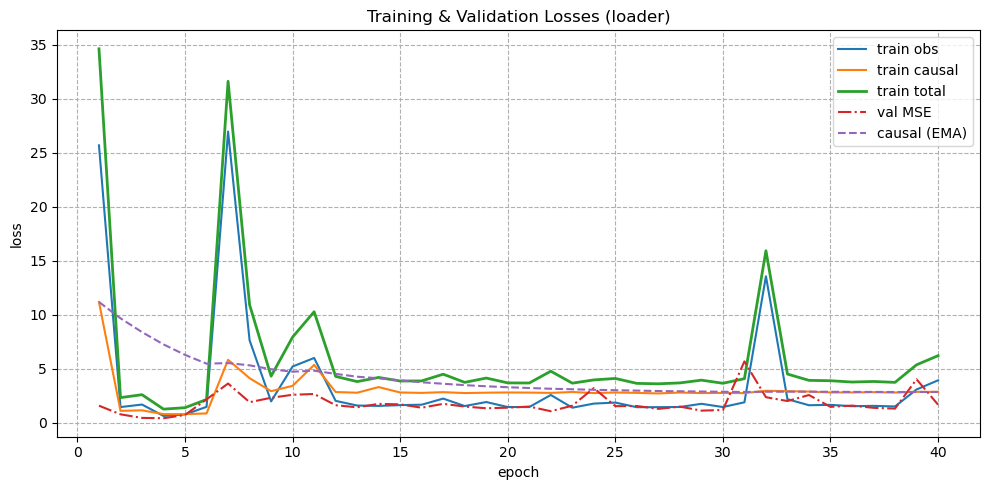

In [147]:
# train once and visualize
from torch.utils.data import Subset

full_dataset = CausalFactorDataset(root_dir=PROCCESSED_DATA_DIR, target_node="VOL", feature_col=None, drop_self_for_target=True)

# --- use it with a DataLoader and plot ---
import pandas as pd, matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

# dataset & split (example)
split = int(0.8*len(full_dataset))
train_loader = DataLoader(Subset(full_dataset, list(range(split))), batch_size=1, shuffle=True)
val_loader   = DataLoader(Subset(full_dataset, list(range(split, len(full_dataset)))), batch_size=1, shuffle=False)

# dims + model
g0 = next(iter(train_loader))
num_features, num_edges = g0.num_node_features, g0.edge_index.size(1)
model = GNN_NCM(num_features=num_features, num_edges=num_edges, gnn_mode='per_edge', hidden_dim=32, out_dim=16)

# train & log
tlog = HybridCausalTrainerLogged(epochs=40, lr=0.01, gamma=0.8)
tlog.set_validation_loader(val_loader)
tlog.train(model, train_loader)

# plot
df = pd.DataFrame(tlog.history)
def ema(x, a=0.15):
    y=[]; s=None
    for v in x: s = v if s is None else a*v + (1-a)*s; y.append(s)
    return y

if not df.empty and "epoch" in df:
    plt.figure(figsize=(10,5))
    plt.plot(df["epoch"], df["loss_obs"],    label="train obs")
    plt.plot(df["epoch"], df["loss_causal"], label="train causal")
    plt.plot(df["epoch"], df["loss_total"],  label="train total", linewidth=2)
    if "val_mse" in df and not df["val_mse"].isna().all():
        plt.plot(df["epoch"], df["val_mse"], label="val MSE", linestyle='-.')
    plt.plot(df["epoch"], ema(df["loss_causal"]), linestyle='--', label="causal (EMA)")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training & Validation Losses (loader)")
    plt.legend(); plt.grid(True, linestyle='--'); plt.tight_layout(); plt.show()
else:
    print("No curve logged — double-check you used HybridCausalTrainerLogged and passed a non-empty loader.")




In [148]:
# --- teacher-free interventional curriculum trainer (single loader; no masks, no teacher) ---

import torch, torch.nn as nn, torch.optim as optim

class InterventionalCurriculumTrainerTeacherFree:
    def __init__(self,
                 epochs_obs=30,
                 epochs_do=150,
                 lr=5e-3,
                 w_obs=0.2,
                 w_do=1.0,
                 weight_decay=1e-4,
                 clip=1.0,
                 # knobs for your causal do(parent) construction
                 neutral='zeros',     # 'zeros' or 'self+delta'
                 delta=0.0):          # scalar or 1D tensor of size F (used when neutral == 'self+delta')
        self.epochs_obs = int(epochs_obs)
        self.epochs_do  = int(epochs_do)
        self.lr  = float(lr)
        self.w_obs = float(w_obs)
        self.w_do  = float(w_do)
        self.wd  = float(weight_decay)
        self.clip = float(clip)

        self.neutral = str(neutral)
        # delta can be float or tensor; we’ll broadcast to feature size later
        self.delta = delta

        self.loss = nn.MSELoss()
        self.history = []

    
    # expects ONE DataLoader of observational snapshots (each g has: x, edge_index, y)
    def train(self, model, loader, val_loader=None, val_node_idx=None):
        dev = next(model.parameters()).device
        model = model.to(dev)

        # -------- Phase 1: observational warm-up (obs only) --------
        opt = optim.AdamW(model.parameters(), lr=self.lr, weight_decay=self.wd)
        for ep in range(1, self.epochs_obs + 1):
            model.train()
            obs_sum, n_obs = 0.0, 0
            for g in loader:
                g = g.to(dev)
                pred = model(g.x, g.edge_index)
                l_obs = self.loss(pred, g.y)

                opt.zero_grad()
                l_obs.backward()
                if self.clip: torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip)
                opt.step()

                obs_sum += float(l_obs.detach()); n_obs += 1

            m_obs = obs_sum / n_obs
            m_val= self.evaluate_obs_mse(model, val_loader, node_idx=val_node_idx)

            self.history.append({
                "epoch": ep, "phase": "obs",
                "loss_obs": m_obs, "loss_do": None, "loss_total": m_obs,
                "val_obs": m_val
            })
            if ep % 10 == 0:
                msg = f"[obs {ep:03d}] obs={m_obs:.6f}"
                if m_val is not None: msg += f" | val_obs={m_val:.6f}"
                print(msg)


        # -------- Phase 2: obs + teacher-free causal (one combined step per batch) --------
        # reset optimizer to avoid stale momentum from Phase 1
        opt = optim.AdamW(model.parameters(), lr=self.lr, weight_decay=self.wd)

        
        for ep in range(1, self.epochs_do + 1):
            model.train()
            obs_sum, do_sum, n_obs, n_do = 0.0, 0.0, 0, 0

            for g in loader:
                g = g.to(dev)
                x, edge_index, y = g.x, g.edge_index, g.y

                # observational term
                p_obs = model(x, edge_index)
                l_obs = self.loss(p_obs, y)
                obs_sum += float(l_obs.detach()); n_obs += 1

                # teacher-free causal term: do(parent) one at a time, aggregate to each child
                l_cau = self._causal_loss_do_parent_average(model, g, p_obs)
                do_sum += float(l_cau.detach()); n_do += 1

                # combine and step once
                total = (self.w_obs * l_obs) + (self.w_do * l_cau)
                opt.zero_grad()
                total.backward()
                if self.clip: torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip)
                opt.step()

            m_obs = obs_sum / max(n_obs, 1) if n_obs else 0.0
            m_do  = do_sum  / max(n_do,  1) if n_do  else 0.0
            total_epoch = (self.w_obs * m_obs) + (self.w_do * m_do if n_do else 0.0)

            m_val= self.evaluate_obs_mse(model, val_loader, node_idx=val_node_idx)

            ep_abs = self.epochs_obs + ep
            self.history.append({
                "epoch": ep_abs, "phase": "do",
                "loss_obs": m_obs, "loss_do": m_do, "loss_total": total_epoch,
                "val_obs": m_val
            })
            if ep % 10 == 0:
                msg = f"[do  {ep:03d}] total={total_epoch:.6f} (obs={m_obs:.6f}, do={m_do:.6f})"
                if m_val is not None: msg += f" | val_obs={m_val:.6f}"
                print(msg)


        return model

    def _causal_loss_do_parent_average(self, model, g, p_obs):
        """
        Implements your causal loss verbatim:
          - For each UNIQUE parent node p (from edges src->dst), compute prediction under do(p)
            where features of p are set to a neutral row ('zeros' or 'self+delta').
          - For each child v, average the do(p)[v] over all parents p of v to form a target.
          - Compare that target to TRUE y[v] (MSE), average over nodes that have parents.

        No teacher labels (y_do) and no masks are used.
        """
        dev = p_obs.device
        x, edge_index, y = g.x, g.edge_index, g.y
        N, F = x.size(0), x.size(1)

        # edges assumed in PyG convention: [2, E] with src = edge_index[0], dst = edge_index[1]
        src, dst = edge_index[0], edge_index[1]
        if src.numel() == 0:
            # no edges -> no parents -> causal term 0 (preserve grad graph/dtype)
            return 0.0 * p_obs.sum()

        unique_parents = torch.unique(src)

        # prepare delta row if needed
        if isinstance(self.delta, torch.Tensor):
            delta_row = self.delta.to(device=dev, dtype=x.dtype)
        else:
            delta_row = torch.full((F,), float(self.delta), device=dev, dtype=x.dtype)

        # compute do(parent) predictions once per parent
        p1_map = {}
        for p in unique_parents.tolist():
            p = int(p)
            if self.neutral == 'zeros':
                new_row = torch.zeros(F, device=dev, dtype=x.dtype)
            else:  # 'self+delta'
                new_row = x[p] + delta_row

            if hasattr(model, "do_intervention") and callable(getattr(model, "do_intervention")):
                p1 = model.do_intervention(
                    x, edge_index,
                    intervened_nodes=torch.tensor([p], dtype=torch.long, device=dev),
                    new_feature_values=new_row.unsqueeze(0)
                )  # [N, ...]
            else:
                # fallback: override node p's features and run a forward pass
                x_do = x.clone()
                x_do[p] = new_row
                p1 = model(x_do, edge_index)  # [N, ...]
            p1_map[p] = p1

        # aggregate targets per child and compare to TRUE y[v]
        loss_causal = 0.0
        count = 0
        for v in range(N):
            parents_v = src[dst == v]
            if parents_v.numel() == 0:
                continue
            vals = []
            for p in parents_v.tolist():
                if p in p1_map:
                    vals.append(p1_map[p][v])  # prediction at node v under do(p)
            if not vals:
                continue
            target_v = torch.stack(vals, dim=0).mean(dim=0)  # averaged target for node v
            loss_causal = loss_causal + self.loss(target_v, y[v])
            count += 1

        return (loss_causal / count) if count > 0 else (0.0 * p_obs.sum())

    @torch.no_grad()
    def evaluate_obs_mse(self, model, loader, node_idx=None):
        model.eval()
        dev = next(model.parameters()).device
        tot, n = 0.0, 0
        for g in loader:
            g = g.to(dev)
            p = model(g.x, g.edge_index)   # [N], [N,1], or [N,C]
            y = g.y                        # [N], [N,1], or [N,C]

            # --- safe, few-line fix for single-node eval ---
            if node_idx is not None and p.shape[0] == y.shape[0]:
                idx = node_idx if torch.is_tensor(node_idx) else torch.tensor([int(node_idx)], device=dev)
                idx = idx.to(torch.long).view(-1)
                p = p.index_select(0, idx)
                y = y.index_select(0, idx)
            # align [N,1] ↔ [N]
            if p.dim()==2 and p.size(-1)==1: p = p.squeeze(-1)
            if y.dim()==2 and y.size(-1)==1: y = y.squeeze(-1)
            # -----------------------------------------------

            tot += self.loss(p, y).item(); n += 1
        return tot / max(n, 1)



[obs 010] obs=0.727465 | val_obs=0.434547
[obs 020] obs=0.420194 | val_obs=0.278144
[do  010] total=0.782552 (obs=0.595495, do=0.663453) | val_obs=1.697103
[do  020] total=0.489540 (obs=0.345085, do=0.420523) | val_obs=0.228634


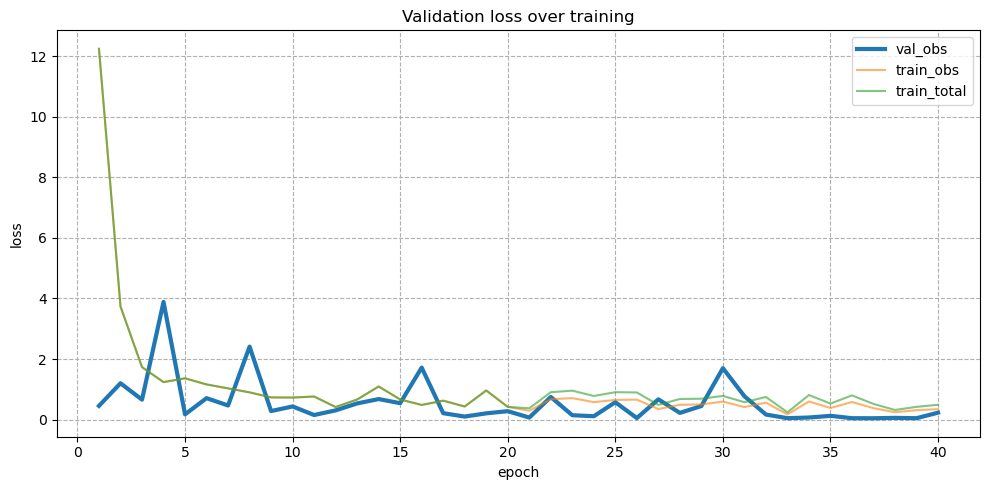

final val_obs = 0.2176530536102212


In [149]:
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

# make loaders
split = int(0.8*len(full_dataset))
train_loader = DataLoader(Subset(full_dataset, range(split)), batch_size=1, shuffle=True)
val_loader   = DataLoader(Subset(full_dataset, range(split, len(full_dataset))), batch_size=1, shuffle=False)

# dims
g0 = next(iter(train_loader))
num_features = g0.num_node_features
num_edges    = g0.edge_index.size(1)

# model
model = GNN_NCM(num_features=num_features, num_edges=num_edges, gnn_mode='per_edge',
                hidden_dim=32, out_dim=16).to(g0.x.device)

# trainer (two-phase, fixed gamma)
trainer = InterventionalCurriculumTrainerTeacherFree(
    epochs_obs=30, epochs_do=20, w_obs=0.2, w_do=1.0,
    neutral='zeros',           # or 'self+delta'
    delta=0                    # scalar or 1D tensor (used only if neutral='self+delta')
)


trainer.train(model, train_loader, val_loader=val_loader, val_node_idx=None)  

# plot
df = pd.DataFrame(trainer.history)

plt.figure(figsize=(10,5))
if "val_obs" in df and df["val_obs"].notna().any():
    plt.plot(df["epoch"], df["val_obs"], label="val_obs", linewidth=3)
if "loss_obs" in df: plt.plot(df["epoch"], df["loss_obs"], label="train_obs", alpha=0.6)
if "loss_total" in df: plt.plot(df["epoch"], df["loss_total"], label="train_total", alpha=0.6)
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Validation loss over training")
plt.legend(); plt.grid(True, linestyle='--'); plt.tight_layout(); plt.show()

print("final val_obs =", trainer.evaluate_obs_mse(model, val_loader, node_idx = None))


## Hyperparameter Selection

In [156]:
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from itertools import product
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
import yaml
import time
import math
import random

def make_loaders(dataset, split=0.8, batch_size=1):
    n = len(dataset)
    s = int(split * n)
    train_idx = list(range(s))
    val_idx   = list(range(s, n))
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, val_idx),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def sample_config(rng, space):
    """Sample one config from a mixed search space with discrete choices and ranges."""
    cfg = {}
    for k, spec in space.items():
        if isinstance(spec, list):
            cfg[k] = rng.choice(spec)
        elif isinstance(spec, tuple) and len(spec) == 2 and all(isinstance(v, (int,float)) for v in spec):
            lo, hi = spec
            # loguniform if key looks like an LR/weight_decay; else uniform
            if any(t in k for t in ["lr", "weight_decay", "wd"]):
                u = rng.uniform(math.log(lo), math.log(hi))
                cfg[k] = float(math.exp(u))
            else:
                cfg[k] = float(rng.uniform(lo, hi))
        else:
            raise ValueError(f"Unsupported search spec for {k}: {spec}")
    return cfg

def tune_hyperparameters_random(dataset, n_trials=40, seed=42, val_node_key=None):
    # Set seeds for reproducibility
    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    train_loader, val_loader = make_loaders(dataset, split=0.8, batch_size=1)
    g0 = dataset[0]
    num_features = g0.num_node_features
    num_edges    = g0.edge_index.size(1)
    device       = g0.x.device


    # ----- define a larger search space -----
    search_space = {
        # model
        "hidden_dim": [16, 32, 64],
        "out_dim":    [8, 16, 32],

        # optimizer
        "lr": (1e-4, 5e-3),            # log-uniform range for random search
        "weight_decay": (1e-6, 1e-3),  # log-uniform range for random search

        # trainer knobs
        "epochs_obs": [20, 40, 60],
        "epochs_do":  [10, 20, 40],
        "w_obs":      [0.1, 0.2, 0.5],
        "w_do":       [0.5, 1.0, 2.0],
        "clip":       [0.5, 1.0, 2.0],
        "neutral":    ["zeros", "self+delta"],
        "delta":      [0.0, 0.1, 1.0],   # only used if neutral == 'self+delta'
    }

    results = []
    best = {"val": float("inf"), "cfg": None, "history": None}

    print(f"Starting random search with {n_trials} trials...")
    for t in tqdm(range(n_trials), desc="Random Search"):
        # Sample a random configuration in each trial
        cfg = sample_config(rng, search_space)

        # build model
        model = GNN_NCM(num_features=num_features, num_edges=num_edges,
                        gnn_mode='per_edge',
                        hidden_dim=int(cfg["hidden_dim"]),
                        out_dim=int(cfg["out_dim"])).to(device)

        # build trainer
        trainer = InterventionalCurriculumTrainerTeacherFree(
            epochs_obs=int(cfg["epochs_obs"]),
            epochs_do=int(cfg["epochs_do"]),
            lr=float(cfg["lr"]),
            w_obs=float(cfg["w_obs"]),
            w_do=float(cfg["w_do"]),
            weight_decay=float(cfg["weight_decay"]),
            clip=float(cfg["clip"]),
            neutral=cfg["neutral"],
            delta=float(cfg["delta"])
        )

        # train with validation tracking
        # Assuming val_node_idx is defined elsewhere in your script
        val_node_idx = None # Placeholder, please define as needed
        trainer.train(model, train_loader, val_loader=val_loader, val_node_idx=val_node_idx)

        # choose best validation obs over epochs
        df = pd.DataFrame(trainer.history)
        if "val_obs" in df and df["val_obs"].notna().any():
            val_best = float(df["val_obs"].min())
        else:
            # fallback: compute once
            val_best = float(trainer.evaluate_obs_mse(model, val_loader, node_idx=val_node_idx))

        results.append({"trial": t, "val_best": val_best, "cfg": cfg})

        if val_best < best["val"]:
            best = {"val": val_best, "cfg": cfg, "history": trainer.history}
            print(f"New best @ trial {t}: val={val_best:.6f} cfg={cfg}")

    # pretty-print best
    print("\n--- Hyperparameter Tuning Complete ---")
    print(f"Best validation loss: {best['val']:.6f}")
    print("Best hyperparameters:")
    print(yaml.safe_dump(best["cfg"], sort_keys=False))
    return best, results


### Saving the Parameters

In [157]:
# Run the tuning process
best, results = tune_hyperparameters_random(full_dataset, n_trials=40, seed=123)  
    
# Save the final config file
# Ensure the configs directory exists

from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))  


os.makedirs('configs', exist_ok=True)

with open('configs/best_config.yaml', 'w') as f:
    yaml.dump(best, f, indent=2, sort_keys=False)
    



Starting random search with 40 trials...


Random Search:   0%|          | 0/40 [00:00<?, ?it/s]

[obs 010] obs=0.053300 | val_obs=0.046752
[obs 020] obs=0.029657 | val_obs=0.015786


Random Search:   2%|▎         | 1/40 [02:10<1:25:08, 130.98s/it]

[do  010] total=0.009711 (obs=0.013293, do=0.014104) | val_obs=0.015925
New best @ trial 0: val=0.015066 cfg={'hidden_dim': np.int64(16), 'out_dim': np.int64(32), 'lr': 0.0001234355613826915, 'weight_decay': 4.582258846275942e-06, 'epochs_obs': np.int64(20), 'epochs_do': np.int64(10), 'w_obs': np.float64(0.2), 'w_do': np.float64(0.5), 'clip': np.float64(1.0), 'neutral': np.str_('self+delta'), 'delta': np.float64(0.1)}


Random Search:   2%|▎         | 1/40 [02:21<1:31:43, 141.12s/it]


KeyboardInterrupt: 

Best hyperparameters: {'lr': 0.01, 'gamma': 0.5, 'hidden_dim': 32, 'out_dim': 16}
